# Binær klassifisering ved hjelp av et nevralt nettverk

## Introduksjon

I denne oppgaven skal det utføres en binær klassifisering av ulike typer bilder. Modellen som skal brukes er et nevralt nettverk med en forholdsvis beskjeden dybde. Den tar et sett med bilde, som skal klassifiseres, samt noen labels som forteller bildenes sanne binære verdi. 
$\color{red}{Mer \, spesifikt \, om \, hvordan \, modellen \, er \, bygget \, opp?}$

Tilnærmingen til problemet er todelt. Først skal det nevrale nettverket trenes. I denne fasen skal parameterne assosiert med hver transformasjon av bildet finnes slik at avviket mellom den reelle klassifiseringen til bildet og modellen sin klassifisering blir minimert. Avviket beregnes ved hjelp av en kostfunksjon,som benytter seg av settet med labels. Dette er essensielt en liste over de ulike punktenes reelle binære klassifisering, slik at modellen sin klassifisering kan sammenlignes med denne. Deretter skal et nytt sett med bilder gjennom en valideringsfase, der disse transformeres ved hjelp av parameterne som ble funnet ui treningsfasen. Deretter kan man trekke en konklusjon om modellen klassifiserer bildene på en god måte eller ikke. 

Denne rapporten består av kode og presentasjon av resultater på to testproblemer:

I testproblem 1 skal punkter i planet klassifiseres. Det skal skilles mellom to typer punkter. Her er de valgt til å være henholdsvis røde og blå. "Bildet" i dette problemet er et punkt, kun beskrevet av to koordinater $(x,y)$. Modellen skal dermed trenes til å avgjøre om et vilkårlig punkt er rødt eller blått.

I testproblem 2 skal siffer fra MNIST klassifiseres. Her er det snakk om virkelige bilder med lav oppløsning. Størrelsen på bildene er 28 x 28 piksler. Bildene i settene fra MNIST består av siffer fra 0-9, dvs 10 ulike klasser av bilder. For at dette skal passe inn i vår binære klassifiseringsmodell holder vi oss til kun to forskjellige siffer, som for eksempel 4 og 9. 

Rapporten tar for seg testproblemene hver for seg. All kode for nettverket og algoritmen som brukes på begge problemene presenteres helt øverst i rapporten. Deretter følger det trening, validering og presentasjon av resultater fra henholdsvis problem 1 og problem 2.


## Modell og algoritme

In [26]:
import math
from plotting import *
from spirals import *
import pickle

def sigma(x):
    return np.tanh(x)

def sigma_der(x):
    return np.cosh(x)**(-2)

def eta(x):
    return 0.5*(1+np.tanh(x/2))

def eta_der(x):
    return np.e**(x)*(np.e**(x)+1)**(-2)

def adam_method(x, x_der, m_jn, v_jn, j):
    beta_1 = 0.9
    beta_2 = 0.999
    alfa = 0.01
    epsilon = 1e-8
    m_j = beta_1*m_jn + (1-beta_1)*x_der
    v_j = beta_2*v_jn + (1-beta_2)* (x_der*x_der)
    m_hatt_j = m_j/(1-beta_1**(j))
    v_hatt_j = v_j/(1-beta_2**(j))
    val = alfa*m_hatt_j/(np.sqrt(v_hatt_j) + epsilon)
    x -= val
    return x, m_j, v_j

def plain_vanilla(x,x_der, tau):
    x -= tau*x_der
    return x

def set_random_parameters(K, d):
    ''' W_k er en dxd matrise og  (2x2 for leketøysmodellen)
        b_k er en dx1 vektor elementer for hver k  (2x1 for leketøysmodellen)
    ''' 
    W_k = np.random.randn(K,d,d)
    b_k = np.random.randn(K,d,1)  
    omega = np.random.randn(d)     
    my = np.random.rand() 
    return W_k, b_k, omega, my


def update_parameters(x, x_der, m_jn, v_jn, tau, j, method="Adam"):
    ''' Updates all parameters ''' 
    if method == "Adam":
        parameter, m_j, v_j = adam_method(x,x_der, m_jn, v_jn, j)
        return parameter, m_j, v_j
    elif method == "Plain":
        x = plain_vanilla(x,x_der, tau)
        return x

def calculate_YKk(Y_Kk, b_k_dim, b_k, K, h, sigma, W_k):
    for i in range(K):
        b_k_dim[i,:,:] = b_k[i,:,:]   
        Y_Kk[i+1,:,:] = Y_Kk[i,:,:] + h*sigma(W_k[i,:,:] @ Y_Kk[i,:,:] + b_k_dim[i,:,:]) 
    return Y_Kk, b_k_dim

def calculate_P_k(omega, Z, c, eta_der, YT_k, my):
    ''' Calculates part (7) of gradient '''
    P_k = np.outer(omega,(Z-c)*eta_der(YT_k @ omega + my)) #Blir en dxI matrise
    return P_k

def calculate_projection_derivatives(eta_der, YT_k, omega, Z, c, Y_Kk, my):
    ''' Calculates parts of gradient (5) and (6) '''
    J_der_my = eta_der(YT_k @ omega + my) @ (Z-c)    #Blir en skalar  
    J_der_omega = Y_Kk[-1,:,:] @ ((Z-c) * eta_der(YT_k @ omega + my)) #Blir en dx1 vektor
    return J_der_my, J_der_omega

def calculate_PKk(K, d, I, P_k, h, W_k, b_k_dim, Y_Kk):
    ''' Calculates P_(k-1) from (8) '''
    P_Kk = np.zeros((K,d,I)) #K matriser, skal ikke ha med P_0
    P_Kk[-1,:,:] = P_k      #Legger P_k bakerst i P_Kk

    for i in range(K-1,0,-1):  #Starter på P_k(=indeks K-1) og helt til og med P_1(=indeks 0)
        P_Kk[i-1,:,:] = P_Kk[i,:,:] + h*np.transpose(W_k[i-1,:,:]) @ (sigma_der(W_k[i-1,:,:] @ Y_Kk[i-1,:,:] +b_k_dim[i-1,:,:]) * P_Kk[i,:,:])
    
    return P_Kk

def calculate_rest_of_gradient(K, d, I, P_Kk, sigma_der, Y_Kk, b_k_dim, h, W_k):
    ''' Calculates parts of gradient (9) and (10) '''
    J_der_W = np.zeros((K,d,d))
    J_der_b = np.zeros((K,d,1))
    vec_I = np.ones((I,1))  #Må gjøre vec_I til en matrise av en eller annen grunn
    #P_Kk går fra P_1(=indeks 0) til P_K(=indeks K-1)
    for i in range(K):
        val = P_Kk[i,:,:] * sigma_der(W_k[i,:,:] @ Y_Kk[i,:,:] + b_k_dim[i,:,:])
        #BLIR DET RETT INDEX PÅ P_KK I VAL? SKULLE DET IKKE VÆRT I+1? ELLER ER P_KK EN MATRISE SOM REPRESENTERER P_K+1 I HEFTET? 
        J_der_W[i,:,:] = h*(val @ np.transpose(Y_Kk[i,:,:]))
        J_der_b[i,:,:] = h*(val @ vec_I)
    return J_der_W, J_der_b

def algorithm(Y_0, c, I, d, iterations, filename, mode="training"):
    K = 15  #antall transformajsoner, kan økes til 15-20
    h = 0.1 #skrittlengde 

    #Forberedelser:
    Y_Kk = np.zeros((K+1,d,I))  #Med K transformasjoner får vi K+1 Y_k'er
    Y_Kk[0,:,:] = Y_0
    b_k_dim = np.zeros((K,d,I))

    J = np.zeros(iterations)
    #Learning parameters (set random startvalues)
    if mode == "testing":
        with open(filename, "rb") as f:
            U = pickle.load(f)
        W_k, b_k, omega, my = U[0], U[1], U[2], U[3]

        Y_Kk, b_k_dim = calculate_YKk(Y_Kk, b_k_dim, b_k, K, h, sigma, W_k)
        #Calculates Z, Y_k-transpose and cost function J
        YT_k = np.transpose(Y_Kk[-1,:,:]) #Enklere notasjon
        Z = eta(YT_k @ omega + my)  #Z er en Ix1 vektor


    elif mode == "training":
        j = 1   #Må starte på 1

        #Til Adam-metoden:
        v_j = np.array([0,np.zeros(d),np.zeros((K,d,1)),np.zeros((K,d,d))])
        m_j = np.array([0,np.zeros(d),np.zeros((K,d,1)),np.zeros((K,d,d))])

        #Til Plain vanilla:
        tau = 0.01

        W_k, b_k, omega, my = set_random_parameters(K, d)

        while j <= iterations:
        
            Y_Kk, b_k_dim = calculate_YKk(Y_Kk, b_k_dim, b_k, K, h, sigma, W_k)

            #Calculates Z, Y_k-transpose and cost function J
            YT_k = np.transpose(Y_Kk[-1,:,:]) #Enklere notasjon
            Z = eta(YT_k @ omega + my)  #Z er en Ix1 vektor

            J[j-1] = 0.5*np.linalg.norm(Z-c)**2 #J blir en array med iterations antall verdier
            
            P_k = calculate_P_k(omega, Z, c, eta_der, YT_k, my)
            
            J_der_my, J_der_omega = calculate_projection_derivatives(eta_der, YT_k, omega, Z, c, Y_Kk, my)
            
            P_Kk = calculate_PKk(K, d, I, P_k, h, W_k, b_k_dim, Y_Kk)
            
            J_der_W, J_der_b = calculate_rest_of_gradient(K, d, I, P_Kk, sigma_der, Y_Kk, b_k_dim, h, W_k)
            
            my, m_j[0],v_j[0] = update_parameters(my, J_der_my, m_j[0], v_j[0], tau, j)
            omega, m_j[1],v_j[1] = update_parameters(omega,J_der_omega,m_j[1],v_j[1], tau, j)
            b_k, m_j[2],v_j[2] = update_parameters(b_k,J_der_b,m_j[2],v_j[2], tau, j)
            W_k, m_j[3],v_j[3] = update_parameters(W_k,J_der_W,m_j[3],v_j[3], tau, j) 

            ''' #Vanilla blir bedre med større skrittlengde synes jeg! Men Adam virker fortsatt litt bedre!
            my = update_parameters(my, J_der_my, m_j[0], v_j[0], tau, j, "Plain")
            omega = update_parameters(omega, J_der_omega,  m_j[0], v_j[0], tau, j, "Plain")
            b_k = update_parameters(b_k,J_der_b,  m_j[0], v_j[0], tau, j, "Plain")
            W_k = update_parameters(W_k, J_der_W,  m_j[0], v_j[0], tau, j, "Plain")
            '''
            j+= 1
        
        U = [W_k, b_k, omega, my]
        with open(filename, "wb") as f:
            pickle.dump(U, f)
        

    return Y_Kk, J, omega, my, Z

def last_function(grid, omega, my): #Used to plot_separation 
    #Måtte dermed ta inn to ekstra argumenter i plot_separation (omega og my)
    ''' A function that takes one argument, and S-by-2 matrix of S intermediate states in
    the network, and returns a vector of S classification values.
    It should multiply by w, add μ and evaluate 𝜂. '''
    Z = eta(np.transpose(grid) @ omega + my) 
    return Z

def forward_function(grid): #Denne kan nok endre til å samsvare med en annen function. (ev kalle den funksjonen inni denne)
    ''' A function that takes one argument, an S-by-2 matrix of S datapoints, and
    returns a vector of S classification values.'''
    b_k_dim = np.zeros((K,d,len(grid[0,:])))
    for i in range(K): 
        b_k_dim[i,:,:] = b_k[i,:,:]   
        grid_k = grid + h*sigma(W_k[i,:,:] @ grid + b_k_dim[i,:,:])
        grid = grid_k

    grid_Tk = np.transpose(grid_k)
    Z = eta(grid_Tk @ omega + my)
    return Z

def plot_cost_function_convergence(iterations, J):
    ''' Plots the convergence of the cost function as a function of the iteration index ''' 
    j_values = [i for i in range(iterations)]
    plt.figure()
    plt.plot(j_values, J)
    plt.xlabel("Iteration index j")
    plt.ylabel("Cost")
    plt.title("Convergence of cost function")
    plt.show()

def stochastic_gradient_descent(I, Y_0, chunk=50): #Denne må implementeres i algoritmen, men jeg skjønner ikke helt hvordan? :(
    ''' Made to pick out pictures to test. Modifies the Adam Descent Algorithm. ''' 
    start = np.random.randint(1,I-chunk)
    Y0_chunk = Y_0[:,start:start+chunk] #picks out 50 pictures! Important to use in MNIST-task. 
    return Y0_chunk, chunk
    
def print_successrate(Z,c, tol=0.05): #Lav toleranse for tvil
    correctly_classified = 0
    for i in range(len(Z)):
        if abs(Z[i]-c[i]) <= tol:
            correctly_classified+=1
    
    print("Ratio of correctly classified points:", correctly_classified/len(c),"(with tolerated difference between classification point and label:",str(tol)+")")


## Testproblem 1 - punkter i planet


#### Trening

* Trener med 40000 interasjoner, 20 lag, 1000 bilder (se nedenfor) og skrittlengde h = 0.1.

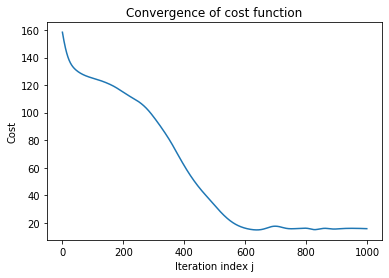

TypeError: plot_separation() takes 4 positional arguments but 6 were given

In [27]:
I = 1000 #Number of pictures (in this case: points)
d = 2 #dimension
iterations = 1000

Y_0, c = get_data_spiral_2d(I) 
c = c[:,0]  #for å få en Ix1 vektor 
Y_Kk, J, omega, my, Z = algorithm(Y_0, c, I, d, iterations, "parameters.txt", "training")

plot_cost_function_convergence(iterations, J)

#plot_progression(Y_Kk, c) 

r = 1000 #resolution of plot*
plot_separation(last_function, Y_Kk[-1,:,:], c, r, omega, my)
#plot_model(forward_function, Y_Kk[0,:,:], c, r) --> må finne en god måte å kalle denne på. Endre på forward_function litt for å få det til!


#### Kommentarer (etter trening): 
* Av "Convergence of cost function"-grafen ser man at funksjonen konvergerer raskt - lenge før alle 40000 iterasjonene er utført. 
* Plott av koordinatene fra det siste laget viser at punktene i hver farge er nøye separert fra hverandre 


#### Testing

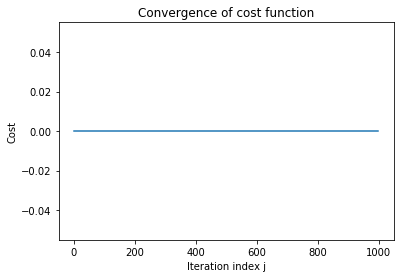

0.0 0.0


TypeError: plot_separation() takes 4 positional arguments but 6 were given

In [28]:
I = 1000 #Number of pictures (in this case: points)
d = 2 #dimension
iterations = 1000
Y_0, c = get_data_spiral_2d(I) #Til oppgave 1: 
c = c[:,0]  #for å få en Ix1 vektor 
Y_Kk, J, omega, my, Z = algorithm(Y_0, c, I, d, iterations, "20K1000B40KIh05.txt", "testing")

plot_cost_function_convergence(iterations, J)

print(J[0],J[-1])  #god overenstemmelse 

#plot_progression(Y_Kk, c) 

r = 1000 #resolution of plot
plot_separation(last_function, Y_Kk[-1,:,:], c, r, omega, my)
print_successrate(Z,c)
plot_model(forward_function, Y_Kk[0,:,:], c, r)
#20 lag, 10000 bilder, 40000 iterasjoner og h = 0.1

### Kommentar til resultatet: 

Resultatet du ser ovenfor er den konfigurasjon, blant de som ble testet, som du kan se i tabellen nedenfor, som ga best mulig klassifikasjon. I cellen under kan du se den konfigurasjonen i tabellen som ga dårligst klassifikasjon.  
FORKLAR HVORDAN FILNAMET ER NAVGITT, SLIK AT HAN DA KAN SE HVA SOM ER TESTET! DA SLIPPER VI Å KJØRE TRENINGEN I JUPYTER OGSÅ, MEN KAN KUN KJØRE TESTINGEN :) (ELLER VI MÅ VEL PLOTTE COST FUNCTION UANSETT)


### Suksessrater: 

Modellen har blitt trent og testet en rekke flere ganger, på samme måte som eksempelet over. Resultatene er presentert i tabellen nedenfor. 

Trente modellen med 40000 iterasjoner. 1000 bilder. K = 20 lag, og hhv h = 0.1, 0.3, 0.5, 0.7 og 0.9.
Deretter kjørte testing på denne dataen med 10, 15 og 30 lag i nettverket. Det er dette man ser i tabellen nedenfor. 

| tol = 0.05 | K = 5  | K = 10 | K = 15 | K = 17 | K = 20 |
|------------|--------|--------|--------|--------|--------|
| h = 0.1    | 0.697  | 0.726  | 0.998  | 0.996  | 0.999  |
| h = 0.3    | 0.5    | 0.5    | 0.368  | 0.997  | 0.234  |
| h = 0.5    | 0.365  | 0.352  | 0.129  | 0.997  | 0.217  |
| h = 0.7    | 0.64   | 0.513  | 0.668  | 0.0    | 0.985  |
| h = 0.9    | 0.392  | 0.597  | 0.995  | 0.678  | 0.995  |

Hvis man ser på J-funksjonen til f.eks h0.9,K17 ser man at det er veldig flaks at den resultatet blir såpass bra etter 40000 iterasjoner, for den konvergerer ikke mot en lav verdi (den oscillerer helt vilt). Dermed kan f.eks denne være interessant å plotte. Dette er nok tilfellet på mange flere av disse derimot (blant de større h-verdiene!). h0.7,K17 hadde nok ikke like flaks. 

Tester heller med K = 5, for å se hvor mye de siste 10-15 lagene har å si!

Toleransen ble satt til 0.05 under klassifiseringen i denne oppgaven, for å se hvor mye modellen kunne få rett når man er mye sikrere enn 50 %. Ved tol 0.5 ble resultatene ...

### Konklusjon

Basert på suksessratene er det åpenbart at det er bedre med flere lag, men man taper altså ikke så mye ved å kutte noen lag. Det ser ut til å gjennomgående fungere bedre når h er mindre, slik at steglengden ikke blir så "voldsom" og kostfunksjonen konvergerer mot en lav verdi (slik den ikke gjør for flere av de større h-ene)

#### Resultater og analyse (Dette skal ikke være med da!)

Ser at resultatet er veldig godt (97.8 % av punktene er klassifisert korrekt med en toleranse på 0.05) når modellen er trent med h = 0.1, 15 lag, 1000 iterasjoner og 1000 bilder. 

Plotting av kostnadsfunksjonen mot tiden viser hvor raskt den konvergerer. 

KANSKJE LAGE EN TABELL OVER DISSE RESULTATENE?
FÅ plot_model til å fungere også, slik at jeg kan plotte modellen + separation for analysen sin del. 

## Testproblem 2 - håndskrevne siffer

#### Trening

In [20]:
from loader import *

I = 12223 #images --> kjører et beskjedent antall blant de 60000, basert på Stochastic Gradient Descent. 
#Blir ca 12000 bilder maksimalt med kun utvalg på to siffer. 
d = 784 # 28x28
Y_0, c = get_dataset()
Y_Kk, J, omega, my, iterations = algorithm(Y_0, c, I, d, "training")

/home/ajo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: overflow encountered in power
/home/ajo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in multiply


MemoryError: Unable to allocate 873. GiB for an array with shape (784, 149401729) and data type float64

#### Testing

In [ ]:
from loader import *

I = 12223 #images --> kjører et beskjedent antall blant de 60000, basert på Stochastic Gradient Descent. 
#Blir ca 12000 bilder maksimalt med kun utvalg på to siffer. 
d = 784 # 28x28
Y_0, c = get_dataset()
Y_Kk, J, omega, my, iterations = algorithm(Y_0, c, I, d, "testing")